In [1]:
from mmdew.bucket_stream2 import BucketStream
from mmdew.bucket_stream_old import BucketStream as OldBucketStream
from sklearn import metrics
import numpy as np
import pandas as pd
from mmdew.mmd import MMD
import numpy.linalg as la
np.random.seed(20)
linear_mmd = MMD(biased=True, gamma=1, kernel="linear")
rbf_mmd = MMD(biased=True, gamma=1, kernel="rbf")
import math
import matplotlib.pyplot as plt

This notebook serves to compare iterative subsampling to 

In [2]:
# print(rbf_mmd.mmd(X,Y))
# # vals = []
# # for i in range(0,10):
# #     vals.append(rbf_mmd.nystroem_mmd(X,Y,m=int(np.sqrt(sample_size))))
# # print(np.mean(vals))
# print(rbf_mmd.nystroem_mmd(X,Y,m=int(np.sqrt(sample_size))))

In [3]:
def k(x,y,gamma=1):
    return metrics.pairwise.rbf_kernel(x, y,gamma)
       

def get_alpha(XX, X_mn, n=1):
    return 1 / n * la.pinv(XX) @ X_mn @ np.ones((n, 1))

def get_subsample_and_weights(X):
    n = len(X)
    # m = int(m_magnitude(n))
    m = round(math.sqrt(n))
    m_idx = np.random.default_rng().integers(n, size=m)
    X_tilde = X[m_idx]
    XX = k(X_tilde, X_tilde)
    X_mn = k(X_tilde, X)
    alpha = get_alpha( XX, X_mn, n)
    return X_tilde, alpha

def get_merged_subsample_and_merged_weights(X_1, X_2, alpha_1, alpha_2, kappa_1, kappa_2):
    
    joined_elements = np.concatenate((X_1, X_2))
    joined_uncompressed_capacity = kappa_1 + kappa_2
    joined_weights = np.concatenate((alpha_1, alpha_2))
   
    
    m = round(math.sqrt(joined_uncompressed_capacity))  # size of the subsample
    #ToDo: uncomment this
    m_idx = np.random.default_rng().integers(len(joined_elements), size=m)
    #m_idx = range(0,m)
    subsample = joined_elements[m_idx]
    K_z = k(subsample, joined_elements)
    #K_m = np.zeros((m, m))  # initialize the kernel matrix with zeros
    #for i in range(m):
        #for j in range(m):
            # reshape to 2D array as rbf_kernel expects 2D array

    K_m = k(subsample, subsample)
    K_m_inv = la.pinv(K_m)
    #breakpoint()
    new_weights = .5 * K_m_inv @ K_z @ joined_weights
   
    # assuming current_elements and previous_elements have the same length



    #breakpoint()

    return subsample, new_weights

def nystroem_mmd_from_weights(X,Y, alpha_1, alpha_2):
    XX = k(X, X)
    YY = k(Y, Y)
    XY = k(X, Y)
    return (alpha_1.T @ XX @ alpha_1 + alpha_2.T @ YY @ alpha_2 - 2 * alpha_1.T @ XY @ alpha_2)[0][0]
    

In [4]:
deviations = pd.DataFrame(columns=['n', 'm', 'reg_deviation', 'nys_deviation','sec_deg_ss_deviation'])
single_vals = pd.DataFrame(columns=['n', 'm', 'reg_deviation', 'nys_deviation','sec_deg_ss_deviation'])
for exponent in range(4,14):
    iter_values_reg = []
    iter_values_nys = []
    iter_values_sec_deg_ss = []
    sample_size = 2 ** exponent
    ss_size = round(math.sqrt(sample_size))
    X = np.random.normal(0, 1, sample_size).reshape(-1,1)
    Y = np.random.normal(0, 1, sample_size).reshape(-1,1)
    for i in range(0,10):
        
        #np.random.seed(20)

        first_degree_size = 2 ** (exponent - 1)
        X_1 = X[:first_degree_size]
        X_2 = X[first_degree_size:]
        Y_1 = Y[:first_degree_size]
        Y_2 = Y[first_degree_size:]

        X_1_ss, alpha_1 = get_subsample_and_weights(X_1)
        X_2_ss, alpha_2 = get_subsample_and_weights(X_2)
        X_ss_merged, X_ss_merged_weights = get_merged_subsample_and_merged_weights(X_1_ss, X_2_ss, alpha_1, alpha_2, first_degree_size, first_degree_size)
        Y_1_ss, alpha_1 = get_subsample_and_weights(Y_1)
        Y_2_ss, alpha_2 = get_subsample_and_weights(Y_2)
        Y_ss_merged, Y_ss_merged_weights = get_merged_subsample_and_merged_weights(Y_1_ss, Y_2_ss, alpha_1, alpha_2, first_degree_size, first_degree_size)
        normal_mmd_value = rbf_mmd.mmd(X,Y)
        nystroem_mmd_value = rbf_mmd.nystroem_mmd(X,Y,round(math.sqrt(sample_size)))
        sec_deg_nystroem_value = nystroem_mmd_from_weights(X_ss_merged,Y_ss_merged, X_ss_merged_weights, Y_ss_merged_weights)
        iter_values_reg.append(normal_mmd_value)
        iter_values_nys.append(nystroem_mmd_value)
        iter_values_sec_deg_ss.append(sec_deg_nystroem_value)
        # print(rbf_mmd.mmd(X,Y))
        # print(rbf_mmd.nystroem_mmd(X,Y,m=int(np.sqrt(sample_size))))
        # print(nystroem_mmd_from_weights(X_ss_merged,Y_ss_merged, X_ss_merged_weights, Y_ss_merged_weights))
        # #print(linear_mmd.nystroem_mmd(X,Y, round(math.sqrt(sample_size))))
        # print(rbf_mmd.nystroem_mmd(X,Y, round(math.sqrt(sample_size))))
        # print(len(X_ss_merged))
        single_vals.loc[(exponent * 10) + i] = [sample_size, ss_size, normal_mmd_value, nystroem_mmd_value, sec_deg_nystroem_value] 
    deviations.loc[exponent-4] = [sample_size, ss_size, np.std(iter_values_reg),np.std(iter_values_nys), np.std(iter_values_sec_deg_ss)]
    

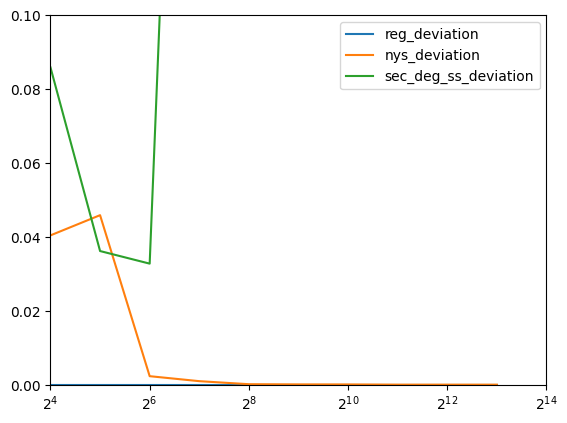

In [8]:
plt.plot(deviations['n'], deviations['reg_deviation'], label='reg_deviation')
plt.plot(deviations['n'], deviations['nys_deviation'], label='nys_deviation')
plt.plot(deviations['n'], deviations['sec_deg_ss_deviation'], label='sec_deg_ss_deviation')

plt.xscale('log', base=2)
# plt.ylim(0,.1)
plt.ylim(0,.1)
plt.xlim(2**4,2**14)
plt.legend()
plt.show()

In [9]:
pd.set_option('display.max_rows', 1000)
single_vals

,n,m,reg_deviation,nys_deviation,sec_deg_ss_deviation
40,16.0,4.0,0.062401,0.114391,0.025780
41,16.0,4.0,0.062401,0.059155,0.184352
42,16.0,4.0,0.062401,0.130459,0.043563
43,16.0,4.0,0.062401,0.087576,0.128856
44,16.0,4.0,0.062401,0.178530,0.129395
45,16.0,4.0,0.062401,0.110782,0.101653
46,16.0,4.0,0.062401,0.145401,0.119074
47,16.0,4.0,0.062401,0.099855,0.211487
48,16.0,4.0,0.062401,0.047920,0.310299
49,16.0,4.0,0.062401,0.165150,0.018642


In [7]:
X_1

array([[ 0.54930785],
       [ 0.80459762],
       [-1.32197996],
       ...,
       [ 0.75218564],
       [-0.2064281 ],
       [ 0.07687889]])